In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import scanpy as sc
import pandas as pd
import scanpy as sc 
import sys 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
sys.path.append('../../src')

from spaceoracle.virtual_tissue import VirtualTissue

/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
2025-07-10 15:21:36.387073: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/lib:/ihome/crc/install/gcc-12.2.0/unixodbc/2.3.11/lib:/ihome/crc/install/sodium/1.0.18/lib:/ihome/crc/install/gcc-12.2.0/r/4.4.0/lib64/R/lib:/ihome/crc/install/gcc-12.2

In [3]:
savefig_params = {
    'dpi': 300, 
    'bbox_inches': 'tight', 
    'format': 'svg', 
    'transparent': True
}

In [4]:
# adata = sc.read_h5ad('/Users/koush/Desktop/training_data/mouse_kidney_13.h5ad')
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_kidney_13.h5ad')

In [5]:
import json

with open('./colors.json', 'r') as f:
    color_dict = json.load(f)

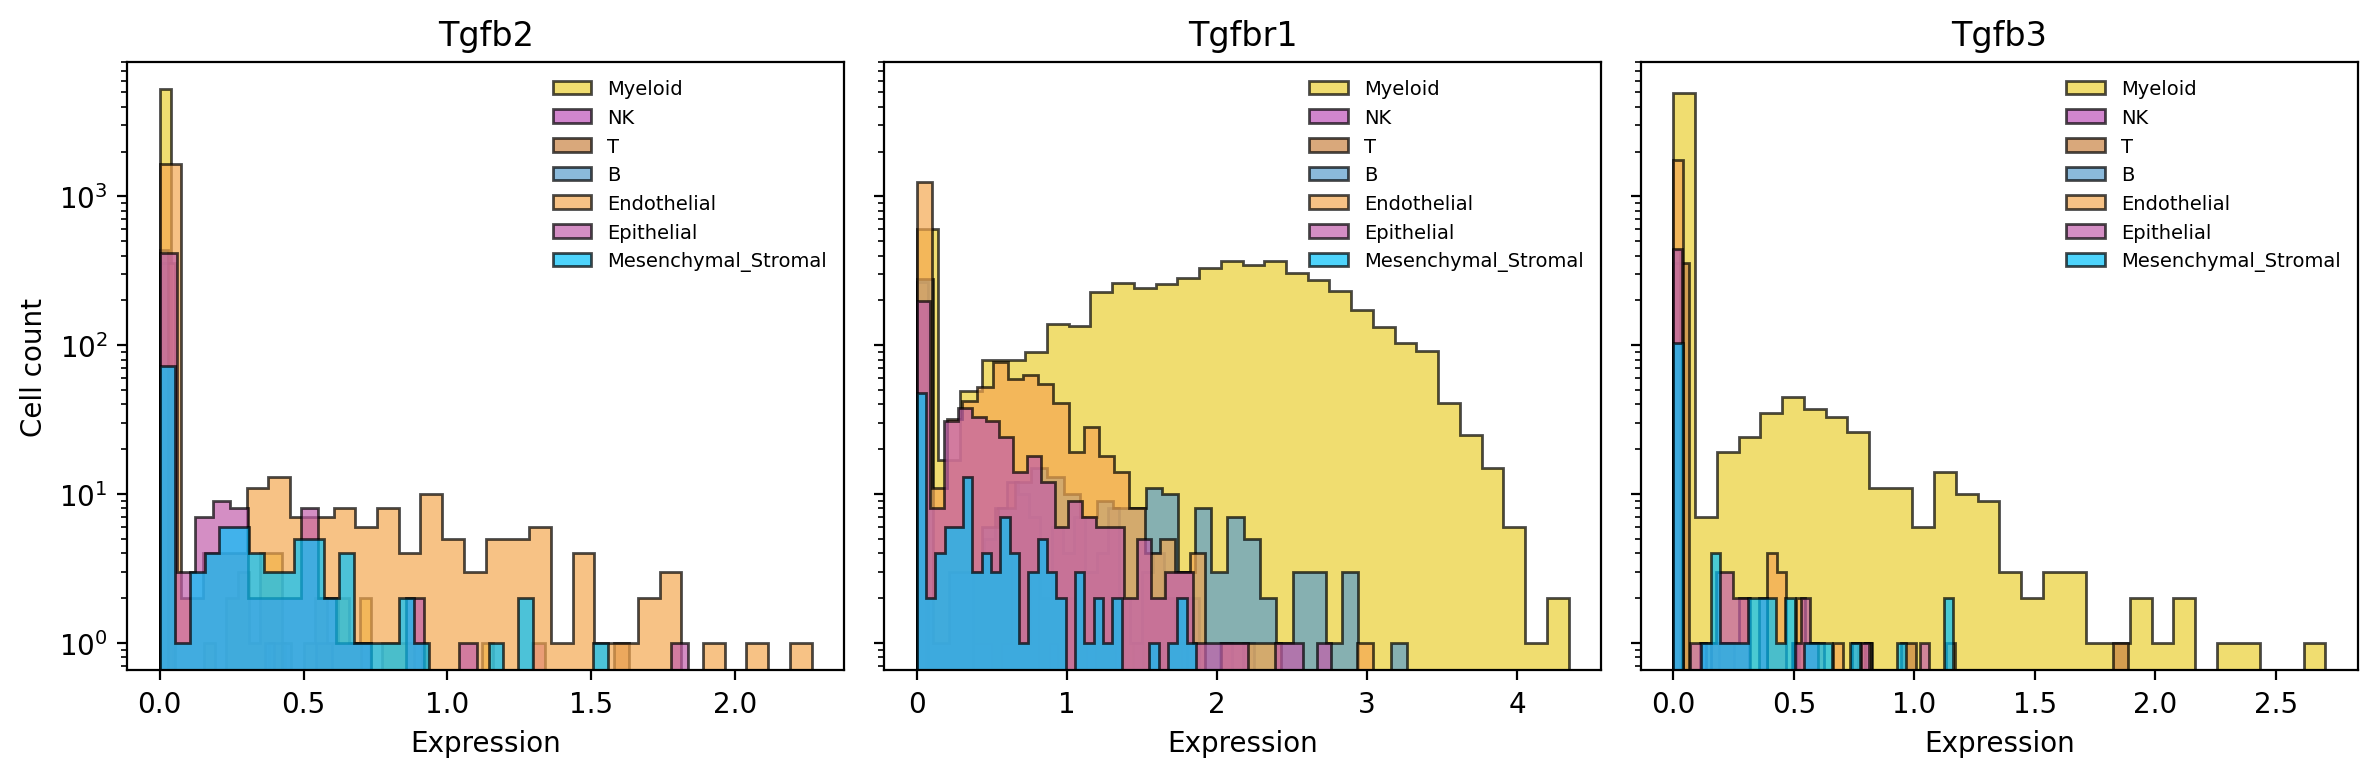

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
genes = ['Tgfb2', 'Tgfbr1', 'Tgfb3']
cell_types = adata.obs['cell_type'].unique()

for ax, gene in zip(axes, genes):
    for ct in cell_types:
        mask = adata.obs['cell_type'] == ct
        expr = adata[mask, gene].layers['normalized_count']
        # If sparse, convert to dense
        if hasattr(expr, "toarray"):
            expr = expr.toarray().flatten()
        else:
            expr = expr.flatten()
        color = color_dict.get(ct, "#333333")
        ax.hist(expr, bins=30, alpha=0.7, label=ct, color=color, histtype='stepfilled', linewidth=1, edgecolor='black')
    ax.set_title(gene)
    ax.set_xlabel('Expression')
    if ax is axes[0]:
        ax.set_ylabel('Cell count')
    else:
        ax.set_ylabel('')
    ax.legend(fontsize=7, loc='upper right', frameon=False)
    ax.semilogy()

plt.tight_layout()
plt.show()


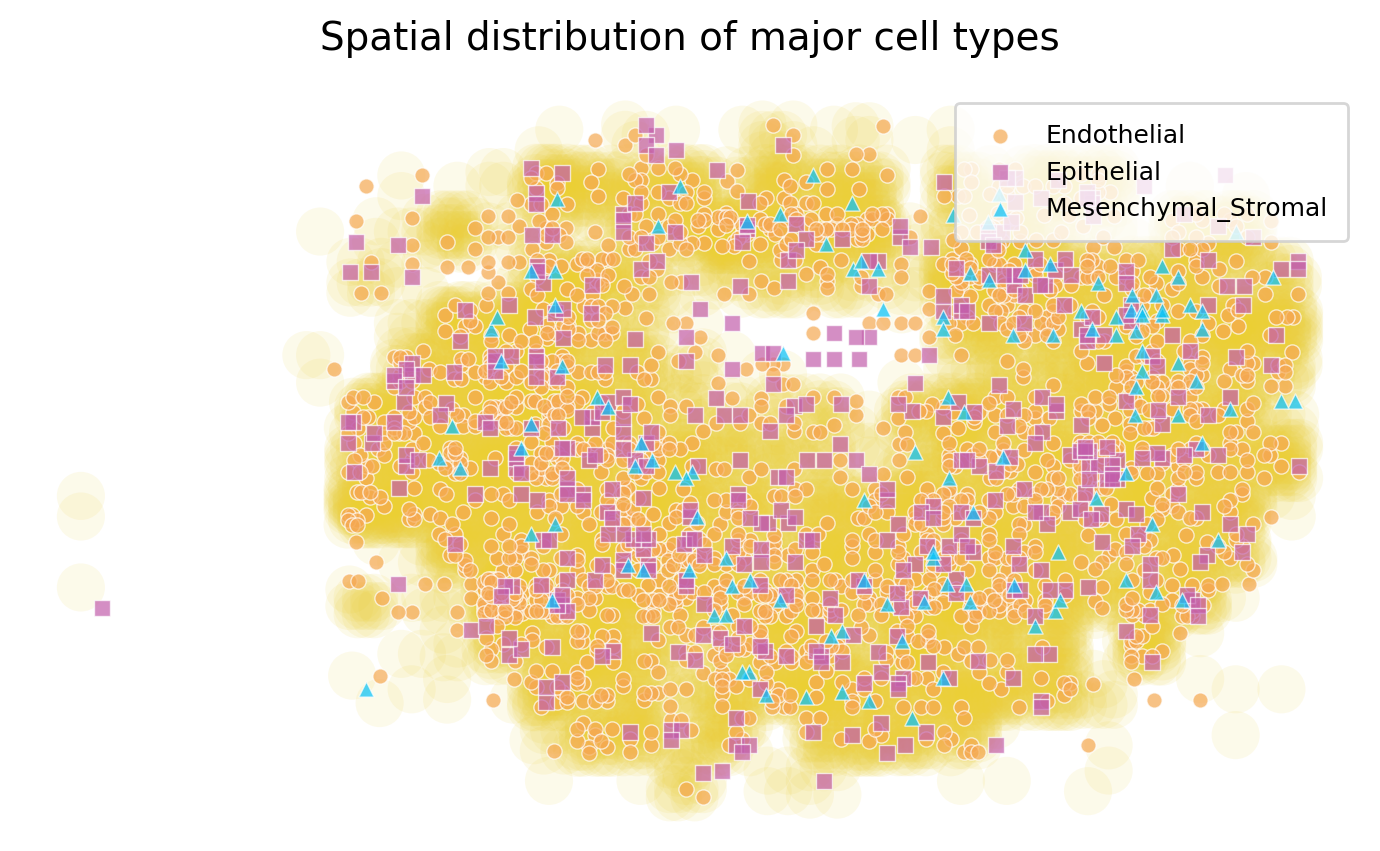

In [125]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.reset_orig()

cell_types_to_plot = ['Endothelial', 'Epithelial', 'Mesenchymal_Stromal']
markers = ['o', 's', '^', 'D']
alphas = [0.7, 0.7, 0.7, 0.7]

ax.scatter(
    adata[adata.obs['cell_type'] == 'Myeloid'].obsm['spatial'][:, 0],
    adata[adata.obs['cell_type'] == 'Myeloid'].obsm['spatial'][:, 1],
    s=300, alpha=0.1, color=color_dict['Myeloid'], edgecolor='none',
)

for ct, marker, alpha in zip(cell_types_to_plot, markers, alphas):
    mask = adata.obs['cell_type'] == ct
    color = color_dict.get(ct, "#333333")
    ax.scatter(
        adata[mask].obsm['spatial'][:, 0],
        adata[mask].obsm['spatial'][:, 1],
        label=ct,
        s=30,
        alpha=alpha,
        edgecolor='white',
        linewidth=0.5,
        marker=marker,
        color=color
    )


ax.set_title("Spatial distribution of major cell types", fontsize=14, pad=15)
ax.set_axis_off()
ax.tick_params(axis='both', which='major', labelsize=10)
ax.legend(fontsize=9, loc='upper right', frameon=True, framealpha=0.8, borderpad=0.8)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()


In [7]:
from spaceoracle.virtual_tissue import VirtualTissue

kidney = VirtualTissue(
    adata = adata,
    annot = 'cell_type',
    betadatas_path = '/ix/djishnu/shared/djishnu_kor11/lasso_runs/mouse_kidney_13',
    ko_path = '/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_kidney_13',
    color_dict=color_dict
)

<Axes: >

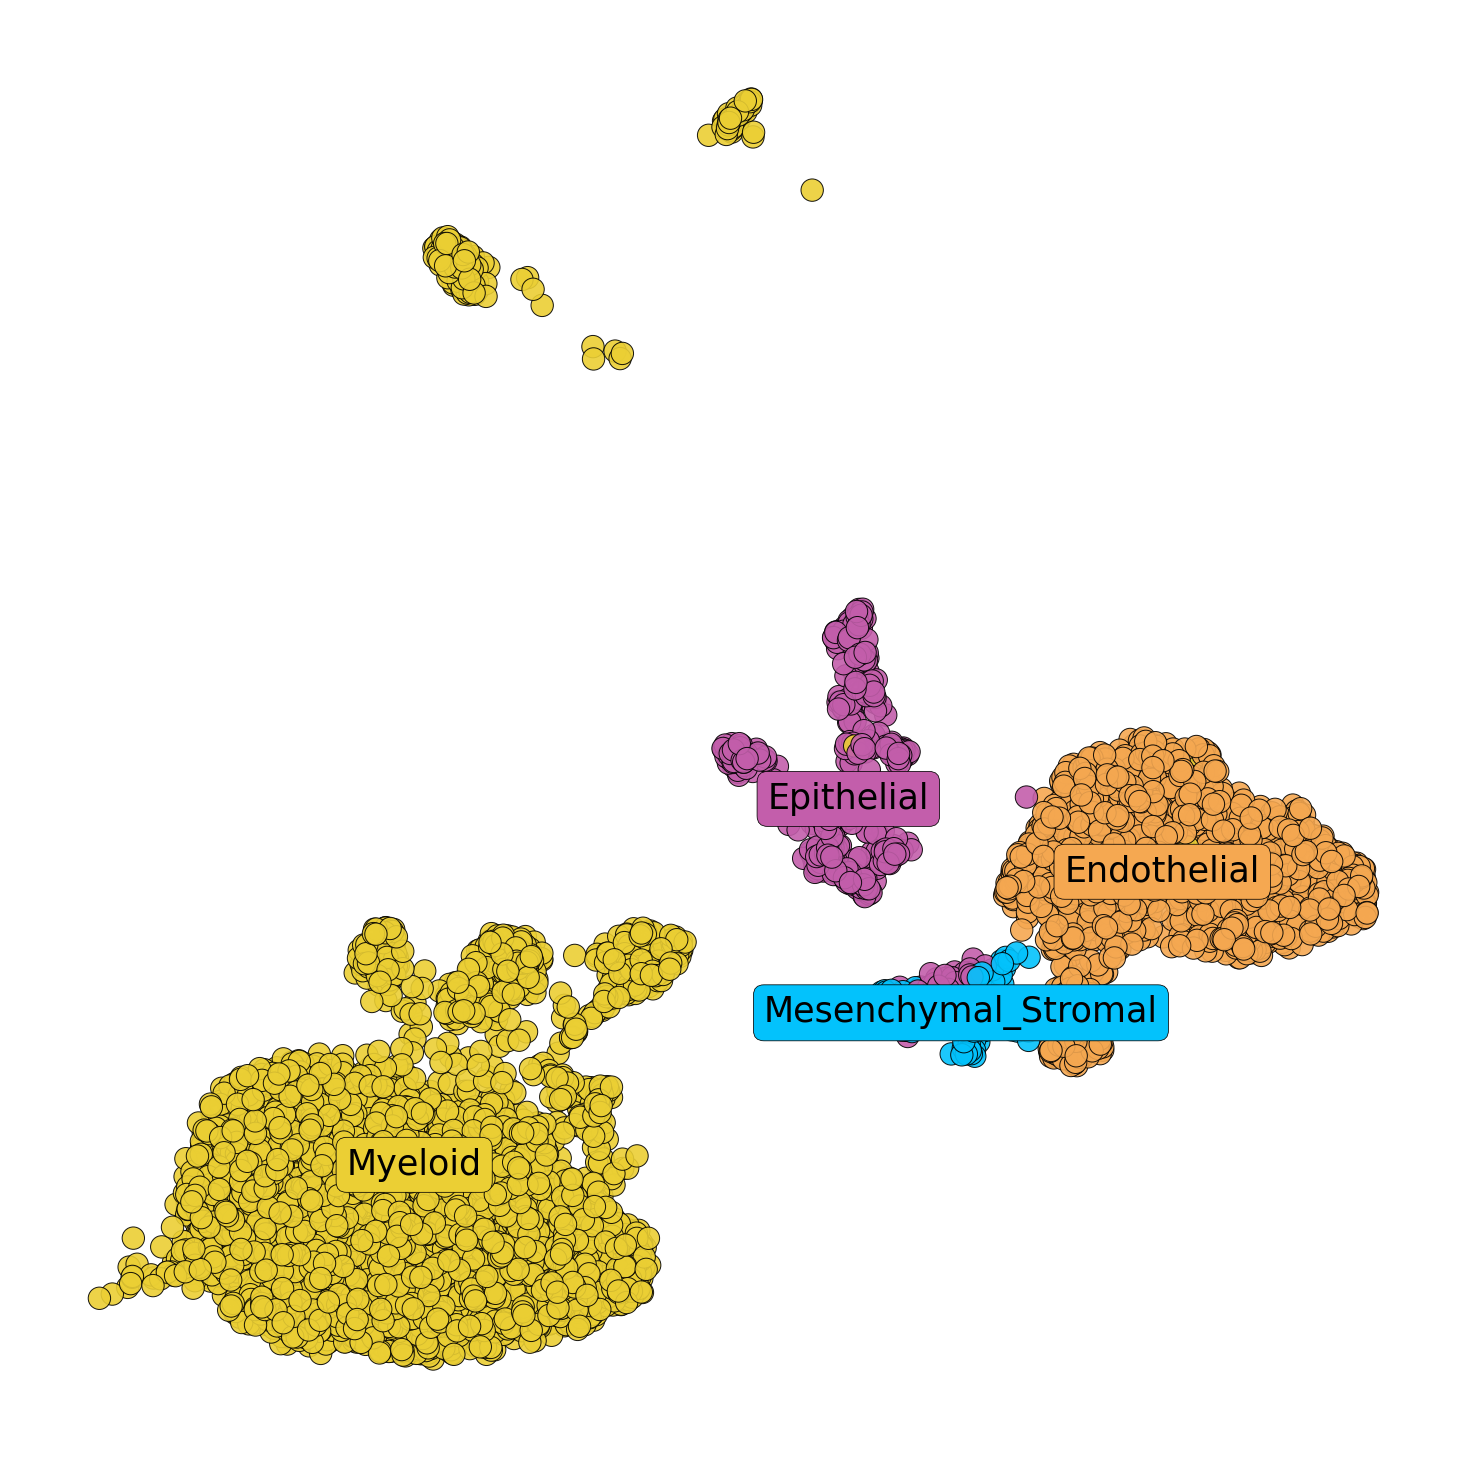

In [8]:
kidney.init_cartography(adata, 
    restrict_to=[
        'Epithelial',
        'Endothelial',
        'Mesenchymal_Stromal',
        'Myeloid'
    ]
)
kidney.chart.plot_umap(
    hue='cell_type',
    color_dict=color_dict,
    scatter_size=20,
    linewidth=0.2,
    legend_fontsize=7,
)

In [9]:
from pathlib import Path

allcells_ko = pd.read_parquet(Path(kidney.ko_path) / 'Tgfb2_4n_0x.parquet')
endothelial_ko = pd.read_parquet(Path(kidney.ko_path) / 'Tgfb2_4n_0x_Endothelial.parquet')
epithelial_ko = pd.read_parquet(Path(kidney.ko_path) / 'Tgfb2_4n_0x_Epithelial.parquet')
mesenchymal_ko = pd.read_parquet(Path(kidney.ko_path) / 'Tgfb2_4n_0x_Mesenchymal_Stromal.parquet')


In [10]:
myeloid_cells = adata[adata.obs['cell_type'] == 'Myeloid'].copy()
len(myeloid_cells)

5266

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import chain

gex_df = adata[myeloid_cells.obs.index, :].to_df(layer='imputed_count')
epsilon = 1e-5
ko_dfs = {
    "All Cells": (allcells_ko.loc[myeloid_cells.obs.index, :] - gex_df) / (epsilon + gex_df),
    "Endothelial": (endothelial_ko.loc[myeloid_cells.obs.index, :] - gex_df) / (epsilon + gex_df),
    "Epithelial": (epithelial_ko.loc[myeloid_cells.obs.index, :] - gex_df) / (epsilon + gex_df),
    "Mesenchymal Stromal": (mesenchymal_ko.loc[myeloid_cells.obs.index, :] - gex_df) / (epsilon + gex_df),
}

pair_comparisons = [
    ('Endothelial', 'Epithelial'),
    ('Endothelial', 'Mesenchymal Stromal'),
    ('Epithelial', 'Mesenchymal Stromal'),
]

info_dict = {}
genes = set()
for g1, g2 in pair_comparisons:
    info_dict[(g1, g2)] = (ko_dfs[g1] - ko_dfs[g2]).mean(axis=0)
    genes.update(info_dict[(g1, g2)].sort_values(key=abs, ascending=False).head(10).index)
    
if 'Tgfb2' in genes:
    genes.remove('Tgfb2')
genes = sorted(list(genes))[::-1]
len(genes)

11

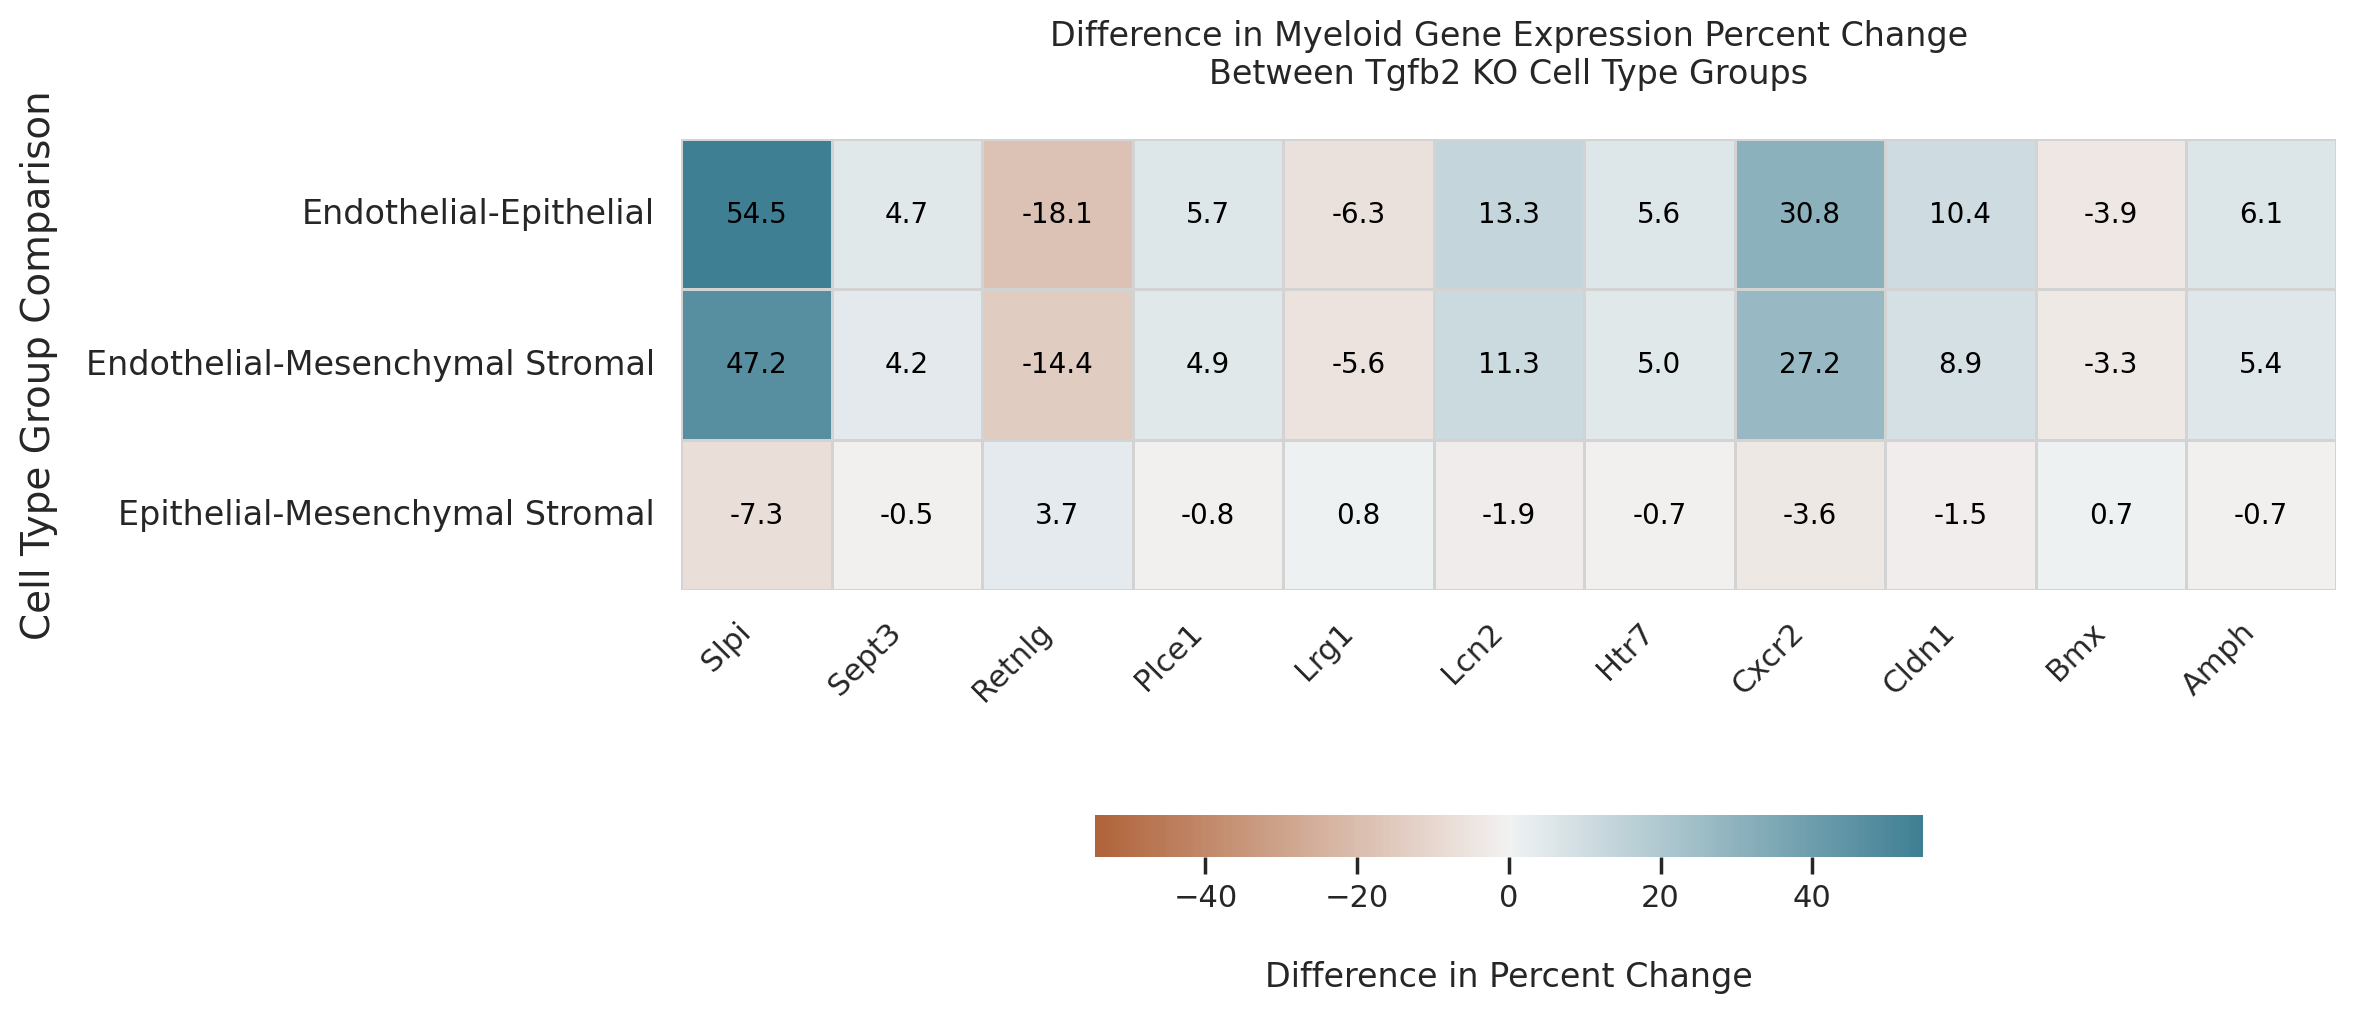

In [107]:
df = pd.DataFrame(info_dict, index=adata.var_names) * 100

fig, ax = plt.subplots(figsize=(12, 8))

# Choose a more visually appealing colormap and style
sns.set(style="whitegrid", font_scale=1.2, rc={"axes.facecolor": "#f7f7f7"})
cmap = sns.diverging_palette(30, 220, as_cmap=True)  # Blue (30) to Orange (220)

# Draw heatmap with colorbar at the bottom and rotated 90 degrees
heatmap = sns.heatmap(
    df.loc[genes].T,
    square=True,
    cmap=cmap,
    annot=True,
    fmt='.1f',
    ax=ax,
    cbar_kws={
        'shrink': 0.5,
        'label': 'Difference in Percent Change',
        'orientation': 'horizontal',
        'ticks': None  # Let seaborn/matplotlib auto-generate ticks
    },
    linewidths=0.5,
    linecolor='lightgrey',
    annot_kws={"size": 10, "color": "black"},
    vmin=-np.nanmax(abs(df.loc[genes].T.values)),
    vmax=np.nanmax(abs(df.loc[genes].T.values)),
)

# Move the colorbar to the bottom and rotate it 90 degrees
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=11)
cbar.set_label('Difference in Percent Change', fontsize=12, labelpad=10)
cbar.ax.xaxis.set_label_position('bottom')
cbar.ax.xaxis.set_ticks_position('bottom')
cbar.ax.xaxis.set_label_coords(0.5, -2.5)
cbar.ax.set_xlabel('Difference in Percent Change', fontsize=12, labelpad=10)
cbar.ax.set_ylabel('')
cbar.ax.set_yticklabels([])
cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation=0)

# Improve axis labels and tick formatting
ax.set_xlabel('', fontsize=14, labelpad=10)
ax.set_ylabel('Cell Type Group Comparison', fontsize=14, labelpad=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)

# Add a more descriptive and styled title
ax.set_title(
    'Difference in Myeloid Gene Expression Percent Change\nBetween Tgfb2 KO Cell Type Groups',
    fontsize=12, pad=20
)

plt.tight_layout()
plt.savefig(
    'figures/Tgfb2_KO_ctdiff_heatmap.svg',
    dpi=300,
    bbox_inches='tight',
    transparent=True,
    format='svg'
)
plt.show()
